In [7]:
# load in the data
words = open("../names.txt", "r").read().splitlines()

In [8]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
# basic stats
print(f"num of names: {len(words)}")
print(f"minimum length word: {min(len(w) for w in words)}")
print(f"max length word: {max(len(w) for w in words)}")

num of names: 32033
minimum length word: 2
max length word: 15


In [4]:
# lets make a frequency distribution of characters
# level 1 = frequency of characters in words
# level 2 = frequency of characters by position (stacked 26 plots)

In [3]:
from typing import Dict, List


def update_counts(word: str, counts: Dict[str, int]) -> None:
    for c in word:
        if c in counts:
            counts[c] += 1
        else:
            counts[c] = 1
    return

def count_all_words(words: List[str]) -> Dict[str, int]:
    counts = {}
    for word in words:
        update_counts(word, counts)
    counts = dict(sorted(counts.items(), key=lambda item: item[1]))
    return counts

In [4]:
# quick test
test_words = ["apple", "banana", "orange", "kiwi"]
counts = count_all_words(test_words)

<BarContainer object of 12 artists>

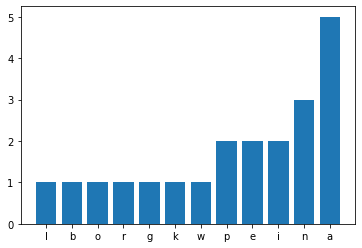

In [5]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())

<BarContainer object of 26 artists>

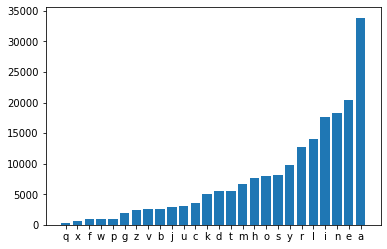

In [10]:
# lets do it for the real thing
counts = count_all_words(words=words)
plt.bar(counts.keys(), counts.values())

In [15]:
# testing out the zip mechanic
# we are effectively creating a sliding window of size 2 across the list
print(test_words)
list(zip(test_words, test_words[1:]))

['apple', 'banana', 'orange', 'kiwi']


[('apple', 'banana'), ('banana', 'orange'), ('orange', 'kiwi')]

In [19]:
# lets get the bigrams aka sliding window of size 2
for w in words[:3]:
    # add the special characters before and after each individual word
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [20]:
from typing import Tuple

# this is fine but very wordy
def update_bigram_counts(bigram: Tuple[str,str], counts: Dict[str, int]):
    if bigram in counts:
        counts[bigram] += 1
    else:
        counts[bigram] = 1
    return

# lets turn that into a function
def get_bigrams(words: List[str]) -> Dict[Tuple[str, str], int]:
    counts = {}
    for word in words:
        # add the special start and end tokens
        chs = ['<S>'] + list(word) + ['<E>']
        for ch1, ch2 in zip(chs, chs[1:]):
            # this is better than the above function
            bigram = (ch1, ch2)
            counts[bigram] = counts.get(bigram, 0) + 1
    return counts

In [29]:
# get the 10 most popular bigrams in order
list(sorted(get_bigrams(words=words).items(), key=lambda kv: -kv[1]))[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [33]:
# get the counts representation as a 2d torch tensor where
# along the rows represents the first character and
# along the columns represents the second character
import torch

def get_bigrams_array(words: List[str]) -> torch.Tensor:
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i for i,s in enumerate(chars)}
    stoi['<S>'] = 26
    stoi['<E>'] = 27
    N = torch.zeros((28, 28), dtype=torch.int32)
    for word in words:
        # add the special start and end tokens
        chs = ['<S>'] + list(word) + ['<E>']
        for ch1, ch2 in zip(chs, chs[1:]):
            N[stoi[ch1], stoi[ch2]] += 1
    return N

In [34]:
N = get_bigrams_array(words=words)

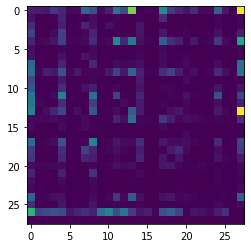

In [35]:
# lets plot this thing
plt.imshow(N)

(-0.5, 27.5, 27.5, -0.5)

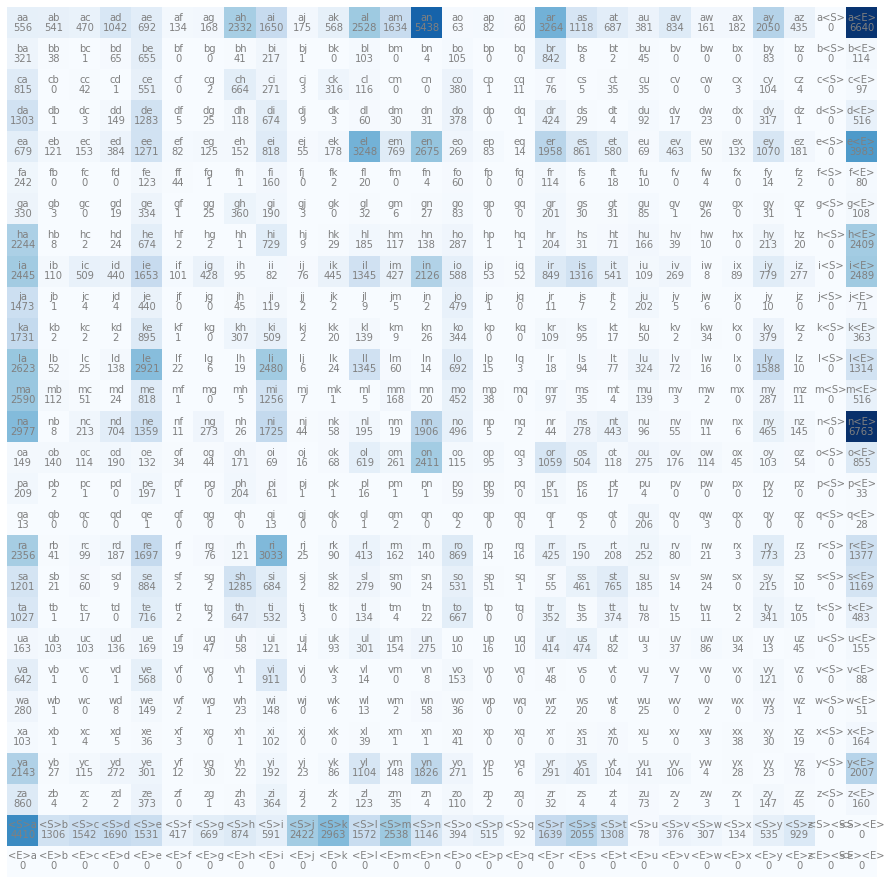

In [40]:
# lets make the plot prettier
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()}
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(28):
    for j in range(28):
        chstr = itos[i]+itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [41]:
N[0]

tensor([ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
        1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
        2050,  435,    0, 6640], dtype=torch.int32)

In [42]:
# sampling from the first row
p = N[0].float()
# need to normalize the row
p = p / p.sum()
p

tensor([0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688, 0.0487,
        0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018, 0.0963,
        0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128, 0.0000,
        0.1960])

In [46]:
# make the sampling from p deterministic
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [48]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 2, 0])

In [57]:
# draw samples for first letter
p = N[stoi["<S>"]].float()
p = p / p.sum()
samples = torch.multinomial(p, num_samples=100, replacement=True, generator=g)
print(samples)
count_all_words([itos[i] for i in samples.tolist()])

tensor([18,  7,  9,  2, 10, 25, 10,  4, 25, 25,  9,  0, 12, 10,  9, 13,  9, 10,
        11,  9,  7, 11, 10, 25,  0, 12,  9, 18,  0,  0,  7, 21, 16, 10, 11, 24,
        10, 18,  0, 17,  0,  0,  7, 10,  3,  1,  0,  0,  0,  9,  0, 12,  0,  0,
         2,  1, 17, 17, 12,  0, 10, 21, 10,  0,  0,  6,  1, 12,  0, 10, 19, 17,
        11, 18, 14, 18, 12, 10,  2,  9, 10, 25,  0, 10, 10, 24, 17,  2,  9, 24,
        18,  0, 10,  3, 17, 24, 24, 12,  0, 25])


{'e': 1,
 'n': 1,
 'q': 1,
 'g': 1,
 't': 1,
 'o': 1,
 'v': 2,
 'd': 2,
 'b': 3,
 'h': 4,
 'c': 4,
 'l': 4,
 'y': 5,
 's': 6,
 'z': 6,
 'r': 6,
 'm': 7,
 'j': 9,
 'k': 16,
 'a': 20}

In [81]:
# lets generate some fake names!
ix = stoi["<S>"]
name = ""
while True:
    p = N[ix].float()
    p = p / p.sum()
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if ix == stoi["<E>"]:
        break
    else:
        name += itos[ix]
print(name)

onlyannn
